# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Краткое-описание" data-toc-modified-id="Краткое-описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Краткое описание</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Импорт-и-константы" data-toc-modified-id="Импорт-и-константы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Импорт и константы</a></span></li><li><span><a href="#Чтение-данных" data-toc-modified-id="Чтение-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чтение данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

## Краткое описание
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель** - построить модель, которая по фотографии будет определять приблизительный возраст человека. 

**Целевая метрика** - MAE.

**Целевое значение**: MAE должно быть меньше 8.

## Описание данных
Данные представляют из себя набор фотографий людей с указанием возраста с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/) (APPA-REAL DATABASE).

Изображения людей находятся в папке `/datasets/faces/final_files`.

Значения целевой переменной находятся в файле `/datasets/faces/labels.csv`. В файле две колонки:
- `file_name` - имя файла с изображением;
- `real_age` - возраст человека на соответствующем изображении.

## Импорт и константы

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
SEED = 42

%matplotlib inline

## Чтение данных
Считаем файл со значениями целевой переменной и создадим генератор батчей для загрузки изображений.

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1/255)

data_flow = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

Found 7591 validated image filenames.


## Исследовательский анализ
Исследуем набор данных и постараемся ответить на следующие вопросы:
- Каков размер выборки?
- Какого распределение возрастов?
- Из каких фотографий состоит набор данных?

Оценим размер выборки.

In [3]:
print(f'Выборка состоит из {labels_df.shape[0]} фотографии')

Выборка состоит из 7591 фотографии


In [4]:
print(f'Размер одного батча {data_flow.batch_size}')
print(f'Всего батчей {len(data_flow)}')

Размер одного батча 32
Всего батчей 238


Выясним как распределены возраста людей в выборке.

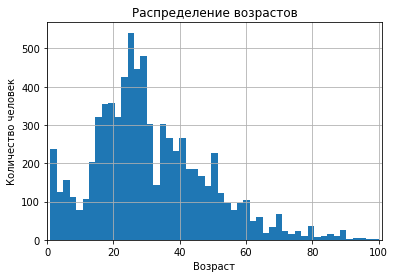

In [5]:
labels_df.real_age.hist(bins=51)

plt.xlim([0, 101])
plt.ylabel('Количество человек')
plt.xlabel('Возраст')
plt.title('Распределение возрастов')

plt.show()

Выведем описательные статистики для возрастов.

In [6]:
labels_df.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Выведем 15 случайно выбранных (генератор батчей перемешивает изображения) фотографий.

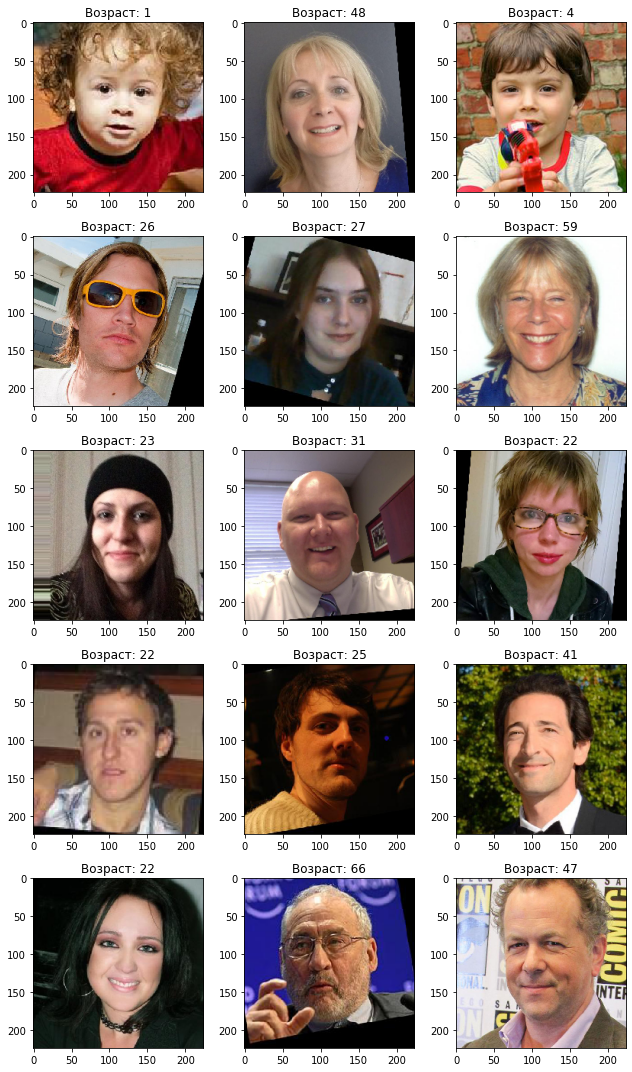

In [7]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))

for row in range(5):
    for col in range(3):
        data = next(data_flow)
        image = data[0][0]
        age = data[1][0]
        
        ax[row, col].imshow(image)
        ax[row, col].set_title(f'Возраст: {age}')
    
plt.tight_layout()    
plt.show()

**Выводы:**
1. Выборка состоит из 7591 фотографии.
1. Фотографии цветные и имеют разное разрешение.
1. Вероятно, набор данных уже содержит аугментации (поворот).
1. На фотографиях мужчины и женщины разных возрастов, на каждом фото по одному человеку, соотношений мужчин и женщин не известно.
1. Форма распределения значений возрастов неравномерная и отличная от формы нормального распределения, меньше всего фотографий людей старше 60 лет.
1. Вероятно, модель будет сильнее ошибаться при определении возраста людей из возрастных групп, представленных меньшим количеством фотографий.

## Обучение модели

Обучение и проверка модели проводится на сервере с GPU. Ниже приведём код для отправки на сервер.

```python
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):

	train_datagen = ImageDataGenerator(
		rescale=1. / 255,
		validation_split=0.25,
		)

	train_dataflow = train_datagen.flow_from_dataframe(
		dataframe=pd.read_csv(path + 'labels.csv'),
		directory=path + 'final_files/',
		x_col='file_name',
		y_col='real_age',
		class_mode='raw',
		target_size=(224, 224),
		batch_size=32,
		subset='training',
		seed=12345,
		)

	return train_dataflow


def load_test(path):

	test_datagen = ImageDataGenerator(
		rescale=1. / 255,
		validation_split=0.25,
		)

	test_dataflow = test_datagen.flow_from_dataframe(
		dataframe=pd.read_csv(path + 'labels.csv'),
		directory=path + 'final_files/',
		x_col='file_name',
		y_col='real_age',
		class_mode='raw',
		target_size=(224, 224),
		batch_size=32,
		subset='validation',
		seed=12345,
		)
	
	return test_dataflow


def create_model(input_shape=(224, 224, 3)):

	resnet = ResNet50(
		input_shape=input_shape,
		weights='imagenet',
		include_top=False,
		)
	resnet.trainable = True


	model = Sequential()

	model.add(resnet)

	model.add(GlobalAveragePooling2D())

	model.add(Dense(1, activation='relu'))

	model.compile(
		optimizer=Adam(lr=1e-4),
		loss='mean_squared_error',
		metrics=['mae']
		)


	return model


def train_model(
	model, 
	train_data, 
	test_data, 
	batch_size=None,
	epochs=10,
	steps_per_epoch=None,
	validation_steps=None
	):

	model.fit(
		train_data,  
    	validation_data=test_data,
    	batch_size=batch_size, 
    	epochs=epochs,
    	steps_per_epoch=steps_per_epoch,
    	validation_steps=validation_steps,
    	verbose=2, 
		)
    
	return model
```

Приведём вывод с сервера - результат обучения 10 эпох и результат тестирования.

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 53s - loss: 257.6616 - mae: 11.4096 - val_loss: 586.6816 - val_mae: 19.1977
Epoch 2/10
178/178 - 44s - loss: 61.0844 - mae: 5.8975 - val_loss: 791.3585 - val_mae: 23.2177
Epoch 3/10
Epoch 4/10
178/178 - 44s - loss: 32.7158 - mae: 4.3839 - val_loss: 569.3763 - val_mae: 19.1833
178/178 - 44s - loss: 21.5768 - mae: 3.5768 - val_loss: 108.3561 - val_mae: 7.8104
Epoch 5/10
178/178 - 43s - loss: 14.9903 - mae: 2.9947 - val_loss: 78.3286 - val_mae: 6.6486
Epoch 6/10
178/178 - 43s - loss: 11.0604 - mae: 2.5734 - val_loss: 69.2753 - val_mae: 6.2518
Epoch 7/10
178/178 - 44s - loss: 9.1680 - mae: 2.3398 - val_loss: 64.6515 - val_mae: 6.0434
Epoch 8/10
178/178 - 44s - loss: 8.4688 - mae: 2.2267 - val_loss: 80.6771 - val_mae: 6.6680
Epoch 9/10
178/178 - 43s - loss: 7.8601 - mae: 2.1135 - val_loss: 65.0827 - val_mae: 6.0281
Epoch 10/10
178/178 - 43s - loss: 7.4809 - mae: 2.0877 - val_loss: 79.7613 - val_mae: 7.0371


60/60 - 10s - loss: 79.7613 - mae: 7.0371
Test MAE: 7.0371
```

## Анализ обученной модели

1. MAE на тестовом множестве приблизительно равно 7, значение целевой метрики достигнуто.
1. С задачей справилась предобученная на `imagenet` модель с архитектурой ResNet50.
1. Модель слегка переобучилась, возможно, следовало попробовать модель попроще.
1. Набор изображений уже содержал аугментации, поэтому они были отключены в `ImageDataGenerator`.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы